 El problema que este notebook está abordando es la predicción de supervivencia de pasajeros del Titanic. Es un problema clásico de clasificación binaria en aprendizaje automático. Aquí hay más detalles:

Contexto histórico:
El Titanic fue un famoso barco que se hundió en su viaje inaugural en 1912, resultando en la muerte de más de 1500 personas.
Objetivo del problema:
Predecir si un pasajero sobrevivió o no al hundimiento del Titanic basándose en varias características del pasajero.
Tipo de problema:
Es un problema de clasificación binaria, donde el resultado (la variable 'Survived') tiene dos posibles valores:

0: El pasajero no sobrevivió
1: El pasajero sobrevivió


Características utilizadas:
El modelo utiliza varias características de los pasajeros para hacer la predicción, incluyendo:

Edad
Sexo
Clase del pasajero (1ª, 2ª o 3ª clase)
Número de hermanos/cónyuges a bordo (SibSp)
Número de padres/hijos a bordo (Parch)
Puerto de embarque

Enfoque de solución:
En este notebook, se utiliza el algoritmo de k-Vecinos más Cercanos (KNN) para resolver el problema. Se explora cómo diferentes valores de k afectan el rendimiento del modelo y se utiliza la validación cruzada para encontrar el mejor valor de k.

### 1. Classification with KNN:

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


warnings.filterwarnings(action='ignore')                  # Turn off the warnings.
%matplotlib inline

#### 1.1. Read in data:

The data and explanation can be found [here](https://www.kaggle.com/c/titanic/data) (requires sign in).

In [113]:
df = pd.read_csv("./75._data_titanic.csv", header='infer')

In [115]:
df.shape

(891, 12)

In [117]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


#### 1.2. Missing value processing: 

In [119]:
# Check for the missing values.
df.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [121]:
# Fill the missing values in the Age variable.
n = df.shape[0]
Age = []                                                               # A temporary list.
for i in range(n):
    if np.isnan(df.Age[i]):
        if ('Mr' in df.Name[i]) or ('Mrs' in df.Name[i]) :
            Age.append(30)                                             # If Mr. or Mrs. in the name, then fill with 30.
        else:
            Age.append(10)                                             # Likely a child. So, fill with 10.
    else:
        Age.append(df.Age[i])
df.Age = pd.Series(Age)

In [123]:
# We will drop some columns.
df = df.drop(columns = ['PassengerId','Name','Ticket','Fare','Cabin'])
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S


In [125]:
# Delete the rest of missing values.
df=df.dropna(axis=0)

In [127]:
df.shape

(889, 7)

#### 1.3. Exploratory data analysis:

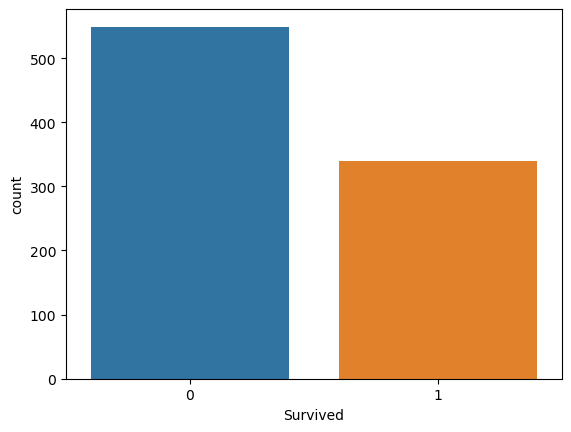

In [129]:
# The frequency table of Survived.
sns.countplot(x='Survived',data=df)
plt.show()

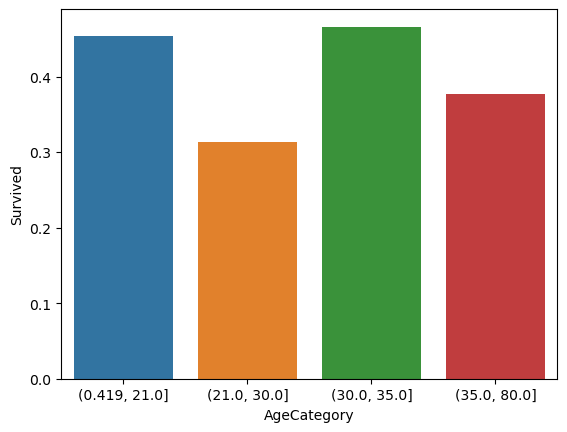

In [131]:
# Survival rate by Age category. 
df['AgeCategory'] = pd.qcut(df.Age,4)                   # Using quantiles cut into 4 intervals.
sns.barplot(x='AgeCategory',y='Survived', ci=None, data=df)
plt.show()

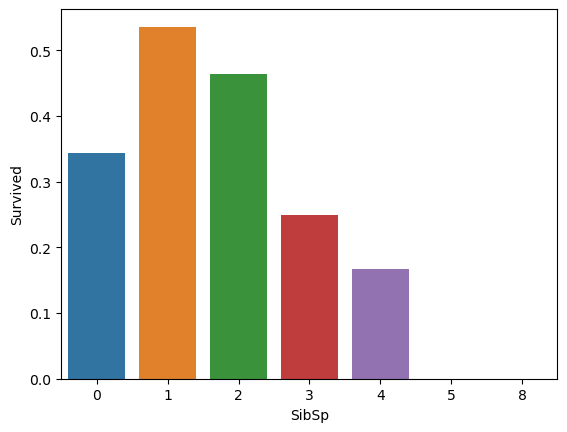

In [133]:
# Survival rate by SibSp category. 
sns.barplot(x='SibSp', y='Survived', ci=None, data=df)
plt.show()

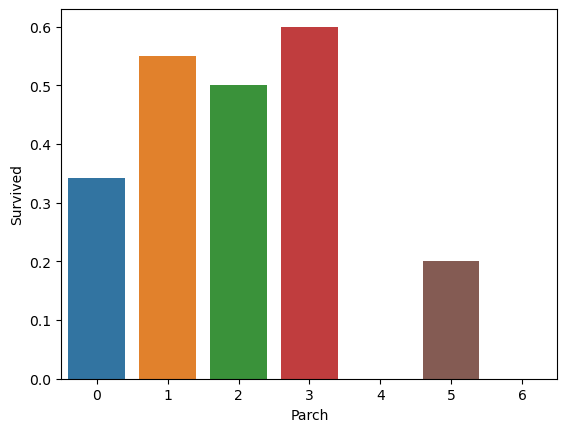

In [135]:
# Survival rate by Parch.
sns.barplot(x='Parch', y='Survived', ci=None, data=df)
plt.show()

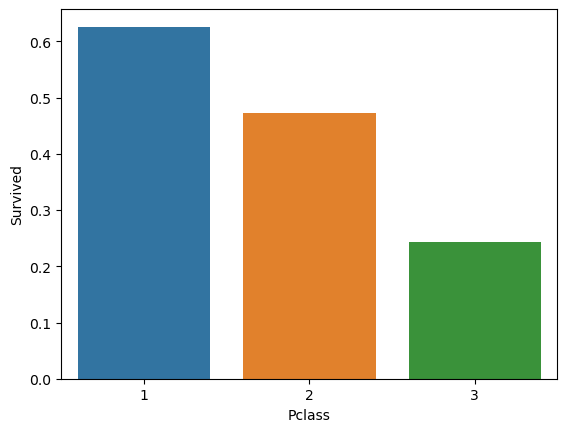

In [137]:
# Survival rate by Pclass.
sns.barplot(x='Pclass', y='Survived', ci=None, data=df)
plt.show()

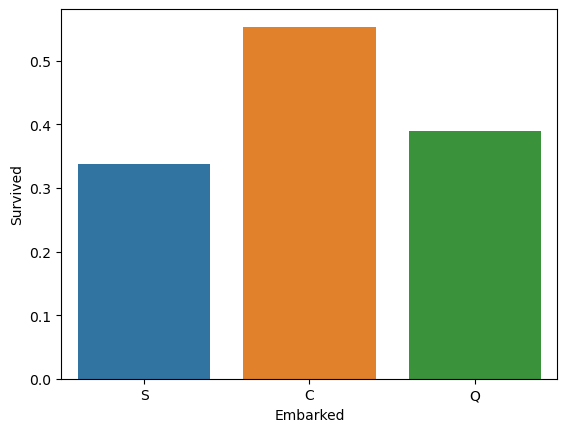

In [139]:
# Survival rate by Embarked.
sns.barplot(x='Embarked', y='Survived', ci=None, data=df)
plt.show()

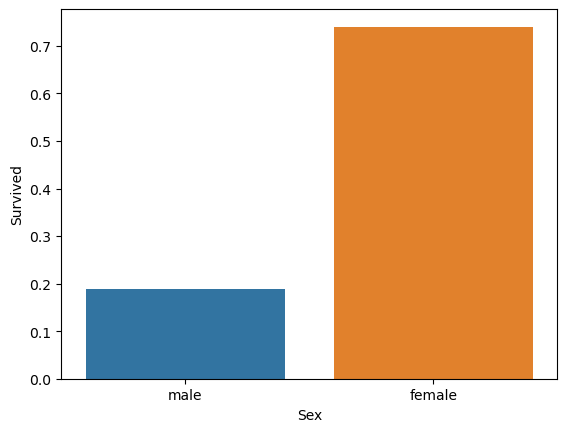

In [141]:
# Survival rate by Sex.
sns.barplot(x='Sex', y='Survived', ci=None,  data=df)
plt.show()

#### 1.4. Feature engineering:

In [143]:
# Convert into dummy variables and then remove the original variables.
df = pd.get_dummies(df.AgeCategory, drop_first=True,prefix='Age').join(df.drop(columns=['Age','AgeCategory']))
df = pd.get_dummies(df.Pclass, drop_first=True,prefix='Pclass').join(df.drop(columns=['Pclass']))
df = pd.get_dummies(df.SibSp, drop_first=True,prefix='SibSp').join(df.drop(columns=['SibSp']))
df = pd.get_dummies(df.Parch, drop_first=True,prefix='Parch').join(df.drop(columns=['Parch']))
df = pd.get_dummies(df.Sex, drop_first=True,prefix='Sex').join(df.drop(columns=['Sex']))
df = pd.get_dummies(df.Embarked, drop_first=True,prefix='Embarked').join(df.drop(columns=['Embarked']))
df.head(5)

,Embarked_Q,Embarked_S,Sex_male,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,SibSp_1,...,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Pclass_2,Pclass_3,"Age_(21.0, 30.0]","Age_(30.0, 35.0]","Age_(35.0, 80.0]",Survived
0,False,True,True,False,False,False,False,False,False,True,...,False,False,False,False,False,True,True,False,False,0
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,1
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,1
3,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,1
4,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,0


In [ ]:
# Save to an external file.
# df.to_csv('data_titanic_2.csv',index=False)

#### 1.5. KNN train and test:

In [145]:
X = df.drop(columns=['Survived'])
Y = df.Survived

In [147]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

In [149]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(622, 20)
(267, 20)
(622,)
(267,)


In [151]:
# Q: Instantiate, fit and predict a KNN with n_neighbours = 5
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, Y_train)
Y_pred = knn5.predict(X_test)
print(metrics.confusion_matrix(Y_test,Y_pred))
print("------------------------")

#Q: Print the accuracy_score
print( "Accuracy : " + str(metrics.accuracy_score(Y_test, Y_pred)))

[[141  17]
 [ 36  73]]
------------------------
Accuracy : 0.8014981273408239


In [153]:
# Instantiate, fit and predict a KNN with n_neighbours = 100
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, Y_train)
Y_pred = knn5.predict(X_test)
print(metrics.confusion_matrix(Y_test,Y_pred))
print("------------------------")

#Q: Print the accuracy_score
print("Accuracy : " + str(metrics.accuracy_score(Y_test,Y_pred)))

[[141  17]
 [ 36  73]]
------------------------
Accuracy : 0.8014981273408239


#### 1.6. KNN bias-Variance tradeoff as function of *k*:   --> Para el bucle de diferentes valores de k 

In [155]:
# Instantiate, fit and predict aKNN with n_neighbours = k
accs = []
k_grid = range(1,100,1)
for k in k_grid:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    accs.append(metrics.accuracy_score(Y_test,Y_pred))

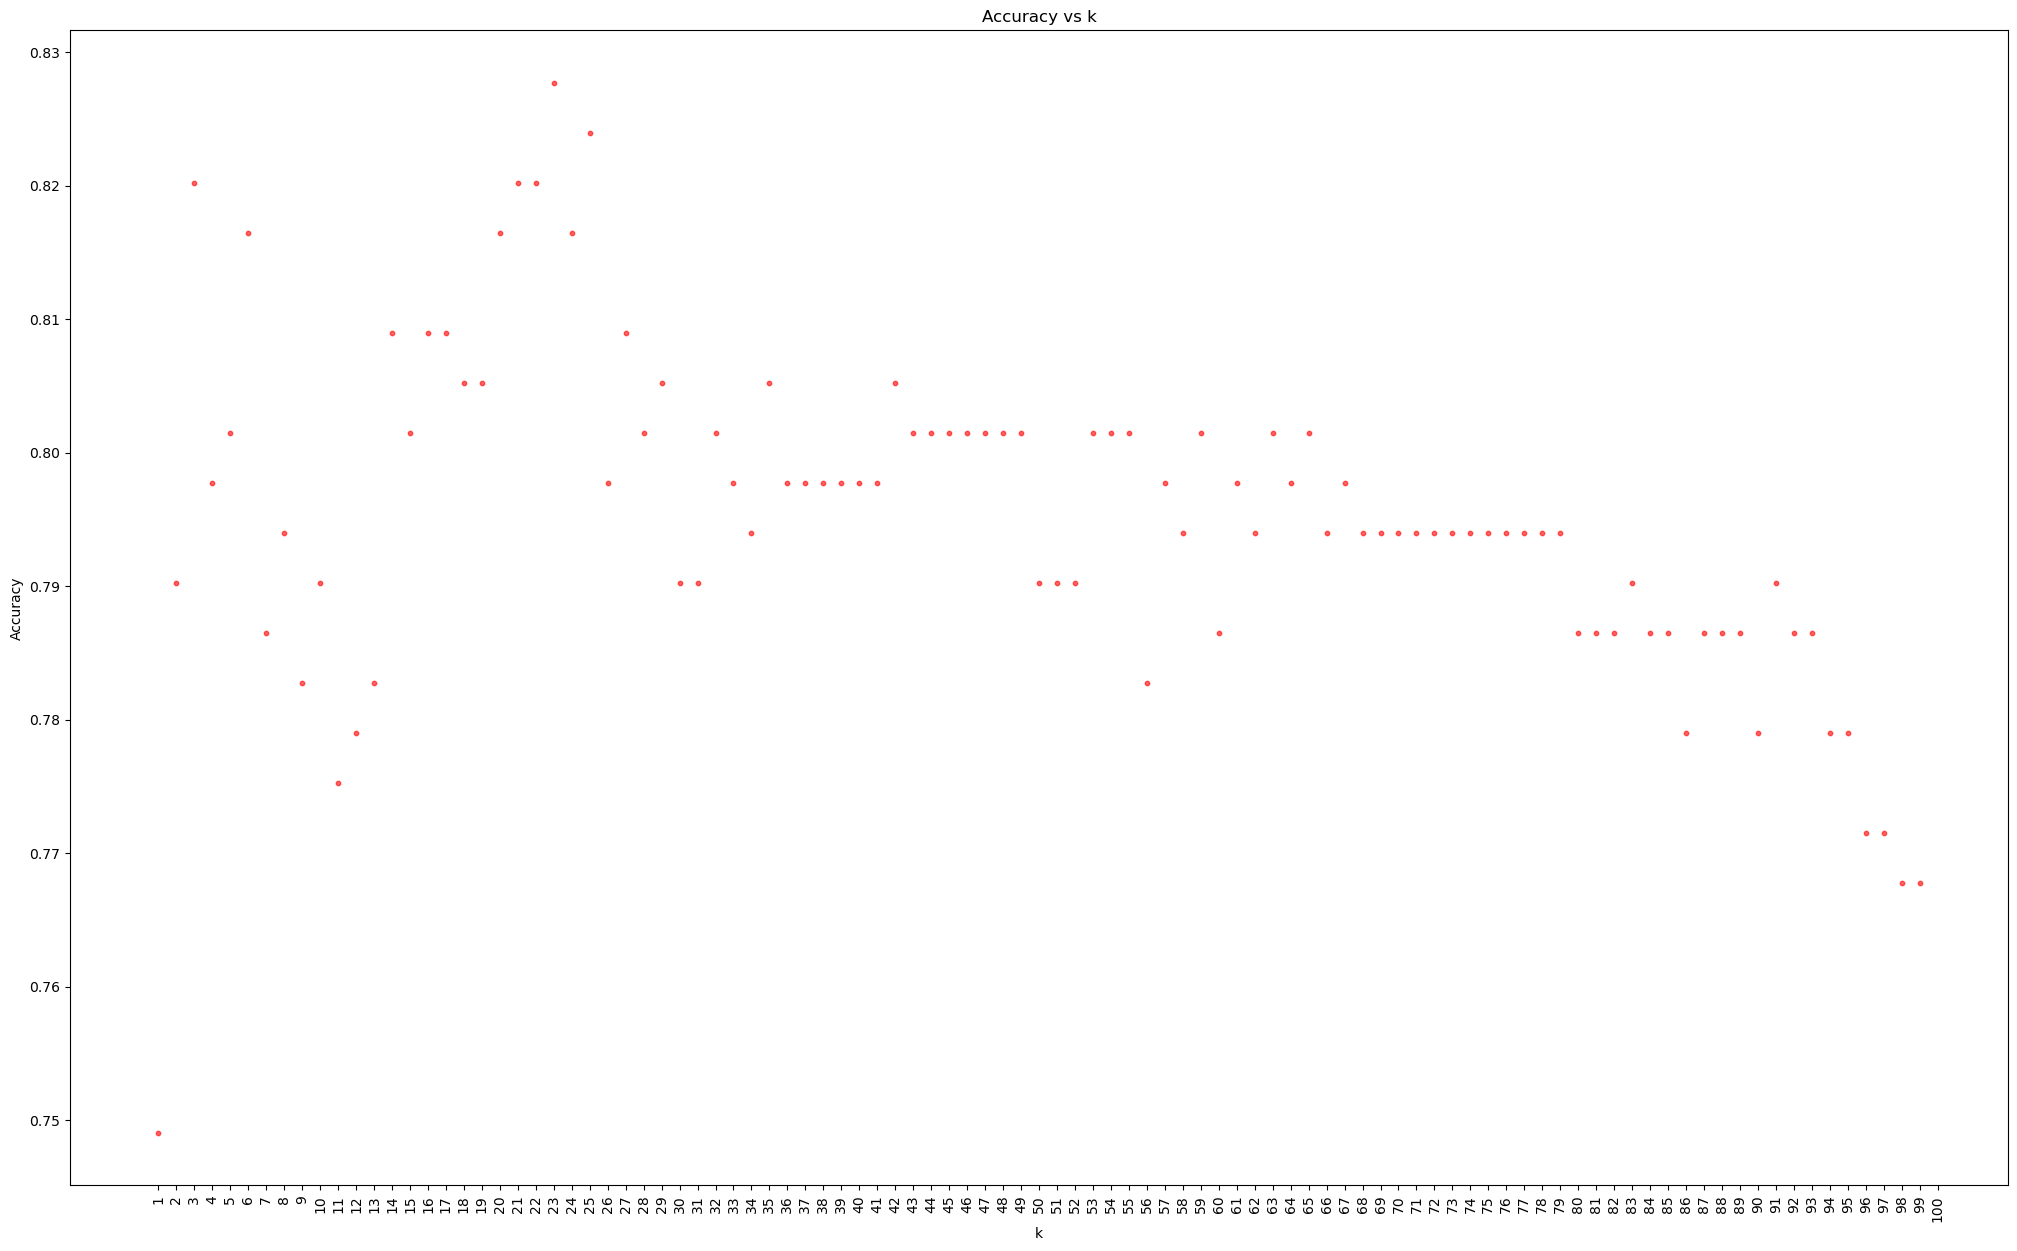

In [157]:
# Visualize.
plt.figure(figsize=(25, 15)) 
plt.scatter(k_grid,accs,c='red',marker='o',s=10,alpha=0.6)
plt.xlabel('k')
plt.xticks(np.arange(1, 101, 1))
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()
# Aquí podemos ver que el mejor valor de k para os datos de test

#### 1.7. KNN hyperparameter optimization:

In [162]:
# Q: Generate a parameter grid for k in [1,51]
k_grid = np.arange(1, 51)
parameters = {'n_neighbors':k_grid}

In [179]:
# Optimizar el valor de k (Búsqueda en malla con validación cruzada [Grid Search CV] usando KNeighborsClassifier como estimador, 
# parámetros, cv = 10 y n_jobs = -1 para utilizar todos los núcleos de la CPU)
gridCV = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters, cv=10, n_jobs=-1)
gridCV.fit(X_train, Y_train)
best_k = gridCV.best_params_['n_neighbors']
print("Best k para datos de entrenamiento: " + str(best_k))

Best k para datos de entrenamiento: 37


## Otra forma de hacerlo es mediante la validación cruzada

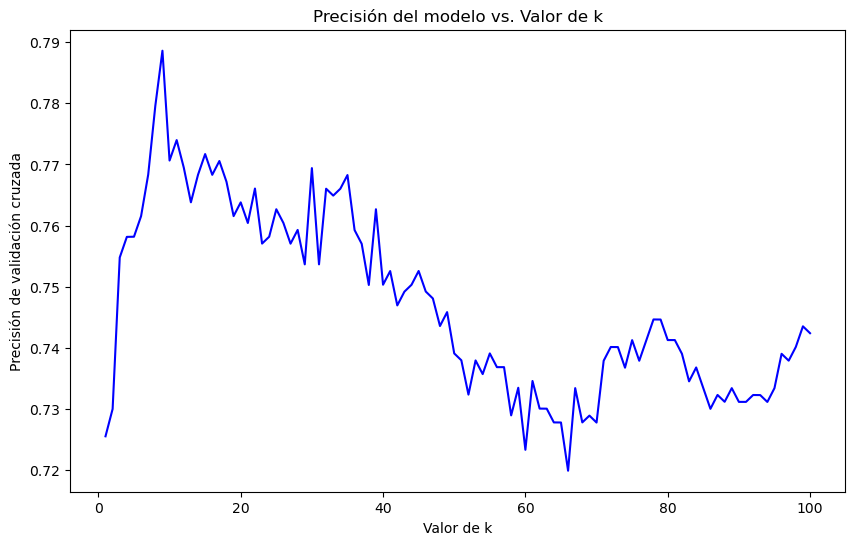

El mejor valor de k es: 9
Con una precisión de validación cruzada de: 0.7886


In [177]:
# Generar un rango de valores k para probar
k_values = [i for i in range(1, 101)]
scores = []

# Normalizar los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Realizar validación cruzada para cada valor de k
from sklearn.model_selection import cross_val_score

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_scaled, Y, cv=10)
    scores.append(np.mean(score))
# Encontrar el mejor k
best_k = k_values[np.argmax(scores)]

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, 'b-')
plt.xlabel('Valor de k')
plt.ylabel('Precisión de validación cruzada')
plt.title('Precisión del modelo vs. Valor de k')
plt.show()

print(f"El mejor valor de k es: {best_k}")
print(f"Con una precisión de validación cruzada de: {max(scores):.4f}")
# Aquí se mirara el punto más alto

In [167]:
# Q: Instantiate, test and predict with the best k.
KNN_best = KNeighborsClassifier(n_neighbors=best_k)
KNN_best.fit(X_train, Y_train)
Y_pred = KNN_best.predict(X_test)
print("Best Accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

Best Accuracy : 0.798


In [174]:
# Q: Instantiate, test and predict with the best k.
KNN_best = KNeighborsClassifier(n_neighbors=23)
KNN_best.fit(X_train, Y_train)
Y_pred = KNN_best.predict(X_test)
print("Best Accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

Best Accuracy : 0.828


Accuracy : 0.8014981273408239 Esta es la precisión obtenida con el modelo KNN inicial (probablemente con k=5, aunque no se especifica en las conclusiones proporcionadas). Significa que el modelo predice correctamente si un pasajero sobrevivió o no en aproximadamente el 80.15% de los casos en el conjunto de prueba.

Best Accuracy : 0.798 Esta es la precisión obtenida con el modelo KNN optimizado, donde se utilizó la búsqueda en cuadrícula (Grid Search) para encontrar el mejor valor de k. En este caso, el modelo optimizado predice correctamente en aproximadamente el 79.8% de los casos en el conjunto de prueba.

Interpretación de estos resultados:

Ambos modelos tienen un rendimiento similar, con una precisión de alrededor del 80%. Esto significa que pueden predecir correctamente la supervivencia de 4 de cada 5 pasajeros en el conjunto de prueba.

Curiosamente, el modelo "optimizado" tiene una precisión ligeramente menor (79.8%) que el modelo inicial (80.15%). Esto puede parecer contradictorio, pero hay varias explicaciones posibles: a) Overfitting: El modelo inicial podría estar sobreajustado a los datos de entrenamiento, lo que resulta en un rendimiento ligeramente mejor en el conjunto de prueba, pero podría no generalizar tan bien a nuevos datos. b) Variabilidad en los datos: La pequeña diferencia (0.3%) podría deberse simplemente a la variabilidad en los datos y no ser estadísticamente significativa. c) Compromiso sesgo-varianza: El modelo "optimizado" podría tener un mejor equilibrio entre sesgo y varianza, lo que podría resultar en un mejor rendimiento en nuevos datos, aunque tenga una precisión ligeramente menor en este conjunto de prueba específico.

La precisión de alrededor del 80% es bastante buena para este tipo de problema. Indica que el modelo KNN puede capturar patrones significativos en los datos para predecir la supervivencia.

Sin embargo, todavía hay un 20% de casos que el modelo no puede predecir correctamente. Esto sugiere que hay factores adicionales que influyen en la supervivencia que no están capturados por las características utilizadas, o que hay un elemento de aleatoriedad en la supervivencia que no puede ser modelado completamente.

En resumen, estos resultados muestran que el modelo KNN, tanto en su versión inicial como optimizada, proporciona una buena capacidad predictiva para el problema de supervivencia en el Titanic. La pequeña diferencia entre los dos modelos sugiere que el modelo inicial ya estaba bastante bien ajustado, y que la optimización adicional no proporcionó una mejora significativa en este caso particular.
